In [1]:
import tushare as ts
import pandas as pd
import numpy as np

In [2]:
# ts 是一个下载数据的包，token是我注册后得到的密码
ts.set_token('d5d1c64ad8e9a27d9605cc7fae6e51ac1658cb7f301403fe89f8f463')
pro = ts.pro_api()
stock_basic = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

In [3]:
# 手动选择10个股票
StockList1 = ['600096','600328','000852','601118','603019','600792','300369','300188','600536','000878','600456','600683']
StockList_basic = stock_basic[stock_basic['symbol'].apply(lambda s: s in StockList1)].reset_index(drop=True)

In [12]:
Data = dict() # key: ts_code, value: DataFrame
start_date = '20160101' #开始日期
adj = 'qfq' #前复权
#for ts_code in stock_basic['ts_code'].values: # 下载全部数据
#for ts_code in StockList_basic['ts_code']: # 下载10个自选股票
for ts_code in ['600536.SH']: # 下载指定一个
    tmp = ts.pro_bar(ts_code=ts_code, adj=adj, start_date=start_date)
    tmp.index = pd.to_datetime(tmp['trade_date'])
    Data[ts_code] = tmp.sort_index(ascending=True)

In [13]:
StockList_basic[['ts_code','name']]

,ts_code,name
0,000852.SZ,石化机械
1,000878.SZ,云南铜业
2,300188.SZ,美亚柏科
3,300369.SZ,绿盟科技
4,600096.SH,云天化
5,600328.SH,中盐化工
6,600456.SH,宝钛股份
7,600536.SH,中国软件
8,600683.SH,京投发展
9,600792.SH,云煤能源


In [14]:
df = Data['600536.SH'].copy()
print(df.head(10))

              ts_code trade_date     open     high      low    close  \
trade_date                                                             
2016-01-04  600536.SH   20160104  35.6403  35.7294  32.1455  32.1455   
2016-01-05  600536.SH   20160105  30.4922  32.9475  29.7002  31.1258   
2016-01-06  600536.SH   20160106  31.3535  31.9277  30.6110  31.8584   
2016-01-07  600536.SH   20160107  30.9179  30.9179  28.6706  28.6706   
2016-01-08  600536.SH   20160108  29.0072  29.7002  26.6807  28.1360   
2016-01-11  600536.SH   20160111  27.2846  28.5122  25.3244  25.3244   
2016-01-12  600536.SH   20160112  25.3442  25.9382  23.4632  24.6809   
2016-01-13  600536.SH   20160113  24.7799  25.3937  23.4632  23.6018   
2016-01-14  600536.SH   20160114  22.5227  24.8888  22.4930  24.6215   
2016-01-15  600536.SH   20160115  24.2552  24.5423  22.7702  23.1365   

            pre_close  change  pct_chg        vol      amount  
trade_date                                                     
2016-01

In [15]:
# 数据库层面

N1 = 20
N2 = 10
N_ATR = 14
win_factor = 3.5
loss_factor = 1.0
# 唐奇安通道
df['N1_HI'] = df.high.shift(1).rolling(N1).max() # 要shift(1),因为做决策是今天开盘以前，参考值是昨天为止的N1天最高价的最大值
df['N1_LO'] = df.low.shift(1).rolling(N2).min()
# ATR
df['TR1'] = df['high'] - df['low'] # 今日最高价 - 今日最低价
df['TR2'] = abs(df['high'] - df['close'].shift(1)) # abs（今天最高价 - 昨日收盘价）
df['TR3'] = abs(df['close'].shift(1) - df['low']) # abs （昨日收盘价 - 今日最低价） 
df['TR'] = np.maximum(np.maximum(df['TR1'],df['TR2']),df['TR3'])
df['ATR'] = df['TR'].rolling(window=N_ATR).mean()

df.dropna(inplace=True) # 因为要算过去若干天的数据，前面若干天没法算
print(df.head(5))

              ts_code trade_date     open     high      low    close  \
trade_date                                                             
2016-02-01  600536.SH   20160201  21.9683  22.2257  20.7704  21.4634   
2016-02-02  600536.SH   20160202  21.2852  23.1266  21.2852  22.6514   
2016-02-03  600536.SH   20160203  22.0376  22.7504  21.6911  22.6019   
2016-02-04  600536.SH   20160204  22.6514  23.6117  22.6118  23.0375   
2016-02-05  600536.SH   20160205  23.2157  23.2652  22.6910  22.7504   

            pre_close  change  pct_chg        vol      amount    N1_HI  \
trade_date                                                               
2016-02-01    22.2653 -0.8019  -3.6016   96008.95  208779.087  35.7294   
2016-02-02    21.4634  1.1880   5.5350  113107.44  257532.677  32.9475   
2016-02-03    22.6514 -0.0495  -0.2185   71134.33  158923.951  31.9277   
2016-02-04    22.6019  0.4356   1.9273   93715.94  219429.269  30.9179   
2016-02-05    23.0375 -0.2871  -1.2462   65234.07  

In [16]:
# global：在Strategy模块的最开始，用于存储、记录信息
signal = 0
Position = list()
cost = 0
Cash = list()
Value_close = list()
BuyTrade = list()
SellTrade = list()

Position.append(0)
Cash.append(20000) # 每一个股票，起始资金20000 （即1/10）
Value_close.append(0)

In [17]:
# LOOP
# time moves by
for today, sub in df.iterrows():
    # portfolio in the morning, i.e. only sub.open available
    # 现在只做看涨，不做空
    if (signal == 1) & (Position[-1] == 0): # 开盘前的信号为购买，且现在空仓
        Position.append(int(Cash[-1] / sub.open / 100) * 100)
        Cash.append(Cash[-1] - Position[-1]*sub.open)
        cost = sub.open
        BuyTrade.append((today, sub.open, Position[-1]))
    elif (signal == -1) & (Position[-1] > 0):
        SellTrade.append((today, sub.open, Position[-1]))
        Cash.append(Cash[-1] + Position[-1] * sub.open)
        Position.append(0)
        cost = 0
    else:
        Position.append(Position[-1])
        Cash.append(Cash[-1])

    #print('Position', Position[-1])
    #print('Cash', Cash[-1])

    # 到了下午 when market closes
    Value_close.append(Position[-1] * sub.close)
    #print('Value',Value_close[-1])

    # 闭市后即第二天开盘前
    # strategy
    if sub.close > sub.N1_HI:
        signal = 1
    elif sub.close < sub.N1_LO:
        signal = -1
    else: signal = 0

    if Position[-1] != 0:
        if win_factor * sub.ATR < (sub.close - cost):
            signal = -1
        elif loss_factor * sub.ATR < (cost - sub.close):
            signal = -1
    #print('signal for tomorrow', signal)

In [18]:
# 如果到回测结束还没有卖出的话，卖出记录少一条，假设以最后一天收盘价卖出）
if len(SellTrade) < len(BuyTrade):
    SellTrade.append((today, sub.close, Position[-1]))

Result = []
for i in range(len(BuyTrade)):
    buytime = BuyTrade[i][0]
    BuyPrice = BuyTrade[i][1]
    pos1 = BuyTrade[i][2]
    selltime = SellTrade[i][0]
    SellPrice = SellTrade[i][1]
    pos2 = SellTrade[i][2]
    Result.append([buytime,selltime,BuyPrice,SellPrice, pos1,pos2])
    
Result = pd.DataFrame(Result, columns=['buytime','selltime','BuyPrice','SellPrice','pos1','pos2'])
Result['DiffPrice'] = Result['SellPrice'] - Result['BuyPrice']
Result['Pct'] = Result['DiffPrice'] / Result['BuyPrice']

win_count = sum(Result['Pct'] >= 0)
loss_count = sum(Result['Pct'] < 0)
win_ret = np.mean(Result[Result['Pct'] >= 0]['Pct'])
loss_ret = np.mean(Result[Result['Pct'] < 0]['Pct'])

print('win {win_count} times, avg return is {ret}%'.format(win_count=win_count, ret=round(win_ret,4)*100))
print('lose {loss_count} times, avg return is {ret}%'.format(loss_count=loss_count, ret=round(loss_ret,4)*100))

win 10 times, avg return is 20.44%
lose 15 times, avg return is -5.46%


<AxesSubplot:xlabel='trade_date'>

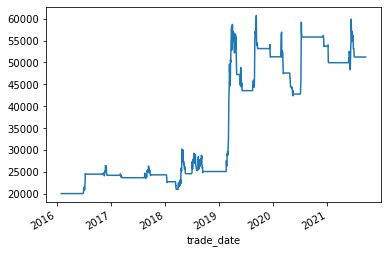

In [19]:
pd.Series(np.array(Value_close)[1:] + np.array(Cash)[1:], index=df.index).plot()

## 提醒

（1）不一定对。。最好把每一步捋一遍
（2）先避免使用面对对象编程，用函数解决问题，效率第一
（3）思考如何模块化，假如分为DATA, STRATEGY, PORTFOLIO 怎样分工，如何传输信息

## 任务

（1）函数封装，做完10个自选股，统计结果（赢多少次，平均赚多少；输多少次，平均亏多少）
（2）这10个自选股是在每一天更新数据，所以需要增加一张总表，记录资产总值每天的绝对值和变化量
（3）计算10个小资产组合（每个资产组合只有一个资产，只是在择时）相互之间的相关性
（4）在10个自选股中挑选表现平常的一个，优化参数
（5）思考一个策略的比较基准是啥